# **CAPSTON PROJECT: SYNERGY CREATORS**

## **TITLE: Kenya Food Price Early Warning System**

## **1.0 BACKGROUND**

Kenya’s food system is under increasing strain due to a combination of climate shocks, market instability, and economic vulnerabilities. Over 3.5 million Kenyans face acute food insecurity, and this number continues to grow amid volatile commodity prices, unpredictable rainfall patterns, and global supply chain disruptions.

Despite agriculture employing over 70% of the rural population and contributing approximately 33% to GDP, most Kenyan farmers are subsistence-based, with limited access to information on market trends, weather forecasts, or soil health. At the same time, humanitarian and government agencies are often forced to respond after food prices have already spiked, when the cost of interventions is highest and their effectiveness is lowest.

A proactive, data-driven approach is urgently needed—one that integrates real-time market data, climate analytics, and economic indicators to provide early warnings and actionable advice to those most affected.

### **1.1 Problem Statement**

Current food security interventions in Kenya are largely reactive. Organizations and governments often respond only after market shocks or harvest failures are already underway. This lag leads to:

- Income instability for smallholder farmers

- Increased vulnerability of poor households to hunger

- Delayed procurement and missed price windows

- Higher humanitarian costs for emergency food aid



For example, a 30% increase in maize prices can push over 500,000 people into acute hunger in a matter of weeks. Without predictive systems in place, stakeholders are left navigating blind.

### **1.4 Objectives**

**i. Food Price Forecasting**

Develop models to predict food price spikes (e.g., >20%) 2–3 months in advance using market data, rainfall, inflation, and other variables.

**ii. Crop Recommendation**

Build a recommendation engine to guide farmers on optimal crops to plant, based on soil, historical weather, and market demand.

**iii. Empower Farmers**

Deliver personalized predictive insights to smallholder farmers to reduce uncertainty and enhance income stability.

**iv. Policy Support**

Provide humanitarian organizations and government agencies with early warning triggers to guide food aid, subsidies, and procurement.

**v. Promote Climate-Smart Agriculture**

Align recommendations with seasonal forecasts and ecological conditions to strengthen long-term climate resilience.

**vi. Align with National Development Goals**

Support Kenya’s Vision 2030 and the Agricultural Sector Transformation and Growth Strategy (ASTGS) through data-enabled farming solutions.

### **1.5 Key Stakeholders**

A successful food price early warning and agricultural advisory system must serve a diverse ecosystem of stakeholders, each with distinct needs, challenges, and decision-making timelines. These stakeholders range from frontline farmers to national policymakers and international humanitarian organizations.

Understanding their roles and tailoring insights to their contexts is essential for the system’s relevance, adoption, and impact.

**Smallholder Farmers (2M+ in Kenya)-** Real-time advice on crop selection, selling windows, and local price outlooks.

**Vulnerable Households (3.5M food insecure)-** Early warnings to adjust household food budgets and coping strategies.

**Government & Policymakers (e.g., MoALF, NDMA)-** Data triggers for timely food subsidies, grain reserves release, or emergency declarations.

**Humanitarian Agencies (e.g., WFP, Red Cross)-** Advance planning for procurement and aid distribution to maximize cost-efficiency.

**Development Partners & Donors-** Evidence-based resource allocation and monitoring of food security trends.

**Commodity Traders & Agribusiness-** Market intelligence and volatility forecasting to inform pricing and logistics.

This system is designed to integrate data science with practical decision-making, offering each stakeholder customized, timely, and actionable intelligence that supports their unique mandates while enhancing coordination across the food system.


### **1.6 CHIRPS: Rainfall Estimates (CHIRPS v3)**

CHIRPS (Climate Hazards Group InfraRed Precipitation with Station data) provides high-resolution (~5 km) rainfall estimates by blending satellite imagery with rain gauge observations. Covering 1981 to present, it delivers reliable daily and monthly rainfall data, ideal for drought monitoring and agricultural planning. In this project, CHIRPS v3 supports analysis of rainfall anomalies affecting food prices and crop recommendations.


In [1]:
import os
import requests

# Download Jan–Dec 2006–2025 monthly CHIRPS TIFFs
base_url = "https://data.chc.ucsb.edu/products/CHIRPS/v3.0/monthly/africa/tifs"
years = range(2006, 2026)
months = [f"{i:02}" for i in range(1, 13)]

os.makedirs("chirps_tifs", exist_ok=True)

for year in years:
    for month in months:
        filename = f"chirps-v3.0.{year}.{month}.tif"
        url = f"{base_url}/{filename}"
        output_path = os.path.join("chirps_tifs", filename)
        
        if not os.path.exists(output_path):
            print(f"Downloading {filename} ...")
            response = requests.get(url, stream=True)
            if response.status_code == 200:
                with open(output_path, 'wb') as f:
                    for chunk in response.iter_content(1024):
                        f.write(chunk)
            else:
                print(f"Failed to download {filename}: {response.status_code}")

# 1.0  Data Preparation

## GADM Shapefile (Admin Boundaries)

We use the GADM shapefile to load Kenya's county and sub-county boundaries. This helps us link food price and weather data to specific regions for analysis and visualization.


In [1]:
!wget -q https://geodata.ucdavis.edu/gadm/gadm4.1/json/gadm41_KEN_2.json.zip && unzip -oq gadm41_KEN_2.json.zip && rm gadm41_KEN_2.json.zip

#### Importing Required Libraries

In [2]:
#importing libraries
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


### **1.1 Dataset loading**
---
#### **Loading and Previewing Rainfall Dataset**

We begin by importing the rainfall data covering Kenya from 2022 to 2024. This dataset will be essential in understanding weather trends and their relationship to food prices and production.

In [3]:
# Load county-level monthly rainfall data
rainfall = pd.read_csv("kenya_county_rainfall.csv")
rainfall.head()

,county,district,date,rainfall_mm
0,Baringo,805,chirps-v3.0.2006.01,17.954037
1,Baringo,BaringoCentral,chirps-v3.0.2006.01,28.755289
2,Baringo,BaringoNorth,chirps-v3.0.2006.01,14.733822
3,Baringo,BaringoSouth,chirps-v3.0.2006.01,20.669492
4,Baringo,EldamaRavine,chirps-v3.0.2006.01,21.707983


#### **Loading and Previewing Food Prices Dataset**

Next, we load the **WFP Food Prices** dataset for Kenya. This dataset contains historical food price data, which is crucial for building our early warning system and understanding price fluctuations across regions and commodities.

In [4]:
# Load food price dataset
prices = pd.read_csv("wfp_food_prices_ken.csv", comment='#')
prices.head()

,date,admin1,admin2,market,market_id,latitude,longitude,category,commodity,commodity_id,unit,priceflag,pricetype,currency,price,usdprice
0,2006-01-15,Coast,Mombasa,Mombasa,191,-4.05,39.67,pulses and nuts,Beans,50,KG,actual,Wholesale,KES,33.63,0.47
1,2006-01-15,Eastern,Kitui,Kitui,187,-1.37,38.02,cereals and tubers,Potatoes (Irish),148,50 KG,actual,Wholesale,KES,1249.99,17.39
2,2006-01-15,Eastern,Kitui,Kitui,187,-1.37,38.02,cereals and tubers,Sorghum,65,90 KG,actual,Wholesale,KES,1800.00,25.03
3,2006-01-15,Eastern,Kitui,Kitui,187,-1.37,38.02,pulses and nuts,Beans (dry),262,KG,actual,Retail,KES,39.00,0.54
4,2006-01-15,Eastern,Marsabit,Marsabit,190,2.33,37.98,cereals and tubers,Maize (white),67,KG,actual,Retail,KES,21.00,0.29


### **Loading markets and counties datasets**

In [5]:
# Load market locations and metadata
markets = pd.read_csv("wfp_markets_ken.csv", comment='#')

# Load county and sub-county boundaries (GADM Level 2)
counties = gpd.read_file("gadm41_KEN_2.json")

In [6]:
#display the price data
prices

,date,admin1,admin2,market,market_id,latitude,longitude,category,commodity,commodity_id,unit,priceflag,pricetype,currency,price,usdprice
0,2006-01-15,Coast,Mombasa,Mombasa,191,-4.05,39.67,pulses and nuts,Beans,50,KG,actual,Wholesale,KES,33.63,0.47
1,2006-01-15,Eastern,Kitui,Kitui,187,-1.37,38.02,cereals and tubers,Potatoes (Irish),148,50 KG,actual,Wholesale,KES,1249.99,17.39
2,2006-01-15,Eastern,Kitui,Kitui,187,-1.37,38.02,cereals and tubers,Sorghum,65,90 KG,actual,Wholesale,KES,1800.00,25.03
3,2006-01-15,Eastern,Kitui,Kitui,187,-1.37,38.02,pulses and nuts,Beans (dry),262,KG,actual,Retail,KES,39.00,0.54
4,2006-01-15,Eastern,Marsabit,Marsabit,190,2.33,37.98,cereals and tubers,Maize (white),67,KG,actual,Retail,KES,21.00,0.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12777,2025-04-15,Rift Valley,Turkana,Kakuma 4,3249,3.74,34.81,miscellaneous food,Salt,185,200 G,aggregate,Retail,KES,11.67,0.09
12778,2025-04-15,Rift Valley,Turkana,Kakuma 4,3249,3.74,34.81,miscellaneous food,Sugar,97,KG,aggregate,Retail,KES,158.33,1.22
12779,2025-04-15,Rift Valley,Turkana,Kakuma 4,3249,3.74,34.81,oil and fats,Oil (vegetable),96,L,aggregate,Retail,KES,313.33,2.42
12780,2025-04-15,Rift Valley,Turkana,Kakuma 4,3249,3.74,34.81,pulses and nuts,Beans (dry),262,KG,aggregate,Retail,KES,151.67,1.17


### **Data pre processing and feature engineering**

####  **Cleaning the Rainfall Dataset**

Before analysis, we need to clean the rainfall dataset to ensure accuracy and consistency. This step includes checking for missing values, correcting column names, and parsing date formats.

In [7]:
rainfall.isnull().sum()  # Check for missing values in rainfall data

county            0
district          0
date              0
rainfall_mm    1638
dtype: int64

In [8]:
rainfall.shape  # Display the shape of the rainfall dataset

(70200, 4)

Filling Nulls of the rainfall_mm with the mean

In [9]:
#Filling Nulls of the rainfall_mm with the mean
rainfall['rainfall_mm'].fillna(rainfall['rainfall_mm'].mean(),inplace=True)

/var/folders/hk/9q5rgqm970gcnk6z0xvy1p7m0000gn/T/ipykernel_97522/1019572118.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rainfall['rainfall_mm'].fillna(rainfall['rainfall_mm'].mean(),inplace=True)


In [10]:
rainfall.isnull().sum() 

county         0
district       0
date           0
rainfall_mm    0
dtype: int64

In [11]:
# Display information about the rainfall dataset
rainfall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70200 entries, 0 to 70199
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   county       70200 non-null  object 
 1   district     70200 non-null  object 
 2   date         70200 non-null  object 
 3   rainfall_mm  70200 non-null  float64
dtypes: float64(1), object(3)
memory usage: 2.1+ MB


#### **Cleaning the Food Prices Dataset**

To prepare the food prices dataset for analysis, we perform basic cleaning steps such as renaming columns, parsing dates, checking for missing values, and standardizing categorical data.

In [12]:
prices.isnull().sum()  # Check for missing values in prices data    

date             0
admin1          34
admin2          34
market           0
market_id        0
latitude        34
longitude       34
category         0
commodity        0
commodity_id     0
unit             0
priceflag        0
pricetype        0
currency         0
price            0
usdprice         0
dtype: int64

In [13]:
prices.head(-50)  # Display the first few rows of the prices dataset

,date,admin1,admin2,market,market_id,latitude,longitude,category,commodity,commodity_id,unit,priceflag,pricetype,currency,price,usdprice
0,2006-01-15,Coast,Mombasa,Mombasa,191,-4.05,39.67,pulses and nuts,Beans,50,KG,actual,Wholesale,KES,33.63,0.47
1,2006-01-15,Eastern,Kitui,Kitui,187,-1.37,38.02,cereals and tubers,Potatoes (Irish),148,50 KG,actual,Wholesale,KES,1249.99,17.39
2,2006-01-15,Eastern,Kitui,Kitui,187,-1.37,38.02,cereals and tubers,Sorghum,65,90 KG,actual,Wholesale,KES,1800.00,25.03
3,2006-01-15,Eastern,Kitui,Kitui,187,-1.37,38.02,pulses and nuts,Beans (dry),262,KG,actual,Retail,KES,39.00,0.54
4,2006-01-15,Eastern,Marsabit,Marsabit,190,2.33,37.98,cereals and tubers,Maize (white),67,KG,actual,Retail,KES,21.00,0.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12727,2025-03-15,Rift Valley,Turkana,Kalobeyei (Village 2),3246,3.76,34.75,cereals and tubers,Rice,52,KG,aggregate,Retail,KES,170.00,1.32
12728,2025-03-15,Rift Valley,Turkana,Kalobeyei (Village 2),3246,3.76,34.75,cereals and tubers,Wheat flour,58,KG,aggregate,Retail,KES,80.00,0.62
12729,2025-03-15,Rift Valley,Turkana,Kalobeyei (Village 2),3246,3.76,34.75,"meat, fish and eggs",Meat (beef),141,KG,aggregate,Retail,KES,600.00,4.65
12730,2025-03-15,Rift Valley,Turkana,Kalobeyei (Village 2),3246,3.76,34.75,"meat, fish and eggs",Meat (camel),344,KG,aggregate,Retail,KES,600.00,4.65


In [14]:
# Rename the admin1 and admin2 columns to match the counties GeoDataFrame 
prices.rename(columns={'admin1': 'Region', 'admin2': 'County'}, inplace=True)
prices.head()

,date,Region,County,market,market_id,latitude,longitude,category,commodity,commodity_id,unit,priceflag,pricetype,currency,price,usdprice
0,2006-01-15,Coast,Mombasa,Mombasa,191,-4.05,39.67,pulses and nuts,Beans,50,KG,actual,Wholesale,KES,33.63,0.47
1,2006-01-15,Eastern,Kitui,Kitui,187,-1.37,38.02,cereals and tubers,Potatoes (Irish),148,50 KG,actual,Wholesale,KES,1249.99,17.39
2,2006-01-15,Eastern,Kitui,Kitui,187,-1.37,38.02,cereals and tubers,Sorghum,65,90 KG,actual,Wholesale,KES,1800.00,25.03
3,2006-01-15,Eastern,Kitui,Kitui,187,-1.37,38.02,pulses and nuts,Beans (dry),262,KG,actual,Retail,KES,39.00,0.54
4,2006-01-15,Eastern,Marsabit,Marsabit,190,2.33,37.98,cereals and tubers,Maize (white),67,KG,actual,Retail,KES,21.00,0.29


In [15]:
prices.shape  # Display the shape of the food prices dataset

(12782, 16)

In [16]:
#Show the rows with missing values in the prices dataset
missing_prices = prices[prices.isnull().any(axis=1)]
missing_prices

,date,Region,County,market,market_id,latitude,longitude,category,commodity,commodity_id,unit,priceflag,pricetype,currency,price,usdprice
2417,2015-01-15,NaN,NaN,Hola (Tana River),1854,NaN,NaN,cereals and tubers,Maize (white),67,KG,actual,Retail,KES,35.00,0.38
2446,2015-02-15,NaN,NaN,Hola (Tana River),1854,NaN,NaN,cereals and tubers,Maize (white),67,KG,actual,Retail,KES,35.00,0.38
2476,2015-03-15,NaN,NaN,Hola (Tana River),1854,NaN,NaN,cereals and tubers,Maize (white),67,KG,actual,Retail,KES,31.00,0.34
2562,2015-06-15,NaN,NaN,Hola (Tana River),1854,NaN,NaN,cereals and tubers,Maize (white),67,KG,actual,Retail,KES,36.00,0.37
2657,2015-09-15,NaN,NaN,Hola (Tana River),1854,NaN,NaN,cereals and tubers,Maize (white),67,KG,actual,Retail,KES,39.25,0.37
2780,2016-01-15,NaN,NaN,Hola (Tana River),1854,NaN,NaN,cereals and tubers,Maize (white),67,KG,actual,Retail,KES,39.17,0.38
2931,2016-06-15,NaN,NaN,Hola (Tana River),1854,NaN,NaN,cereals and tubers,Maize (white),67,KG,actual,Retail,KES,41.70,0.41
2994,2016-08-15,NaN,NaN,Hola (Tana River),1854,NaN,NaN,cereals and tubers,Maize (white),67,KG,actual,Retail,KES,53.45,0.53
3059,2016-10-15,NaN,NaN,Hola (Tana River),1854,NaN,NaN,cereals and tubers,Maize (white),67,KG,actual,Retail,KES,58.00,0.57
3090,2016-11-15,NaN,NaN,Hola (Tana River),1854,NaN,NaN,cereals and tubers,Maize (white),67,KG,actual,Retail,KES,50.00,0.49


In [17]:
#Dropping the rows with missing values 
prices.dropna(inplace=True)

In [18]:
prices.isnull().sum()  # Check for missing values in prices data

date            0
Region          0
County          0
market          0
market_id       0
latitude        0
longitude       0
category        0
commodity       0
commodity_id    0
unit            0
priceflag       0
pricetype       0
currency        0
price           0
usdprice        0
dtype: int64

## 1.2 **Merging foodprices and rainfal Datasets**

We merge the food prices dataset with rainfall data to incorporate weather context into our analysis.  
This helps us explore how rainfall patterns may affect food prices across counties and months.


In [19]:
# Create geometry column
geometry = [Point(xy) for xy in zip(prices["longitude"], prices["latitude"])]
gdf_markets = gpd.GeoDataFrame(prices, geometry=geometry, crs="EPSG:4326")


In [20]:
# Spatial join: assign county/district to each market
market_with_location = gpd.sjoin(gdf_markets, counties, how="left", predicate='within')

# Extract year-month from the custom CHIRPS format
rainfall['month'] = rainfall['date'].str.extract(r'(\d{4}\.\d{2})')
# For prices.csv (market_with_location)
market_with_location['month'] = pd.to_datetime(market_with_location['date']).dt.to_period('M').astype(str)

# For rainfall
rainfall['month'] = rainfall['month'].str.replace('.', '-', regex=False)

In [21]:
# Merge prices with rainfall data
prices_rainfall = pd.merge(
    market_with_location,
    rainfall,
    how="left",
    left_on=["NAME_1", "NAME_2", "month"],
    right_on=["county", "district", "month"]
)

prices_rainfall

,date_x,Region,County,market,market_id,latitude,longitude,category,commodity,commodity_id,...,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,month,county,district,date_y,rainfall_mm
0,2006-01-15,Coast,Mombasa,Mombasa,191,-4.05,39.67,pulses and nuts,Beans,50,...,NA,Constituency,Constituency,6,NA,2006-01,Mombasa,Mvita,chirps-v3.0.2006.01,1.223553
1,2006-01-15,Eastern,Kitui,Kitui,187,-1.37,38.02,cereals and tubers,Potatoes (Irish),148,...,NA,Constituency,Constituency,72,NA,2006-01,Kitui,KituiCentral,chirps-v3.0.2006.01,14.709594
2,2006-01-15,Eastern,Kitui,Kitui,187,-1.37,38.02,cereals and tubers,Sorghum,65,...,NA,Constituency,Constituency,72,NA,2006-01,Kitui,KituiCentral,chirps-v3.0.2006.01,14.709594
3,2006-01-15,Eastern,Kitui,Kitui,187,-1.37,38.02,pulses and nuts,Beans (dry),262,...,NA,Constituency,Constituency,72,NA,2006-01,Kitui,KituiCentral,chirps-v3.0.2006.01,14.709594
4,2006-01-15,Eastern,Marsabit,Marsabit,190,2.33,37.98,cereals and tubers,Maize (white),67,...,NA,Constituency,Constituency,47,NA,2006-01,Marsabit,Saku,chirps-v3.0.2006.01,6.539468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12743,2025-04-15,Rift Valley,Turkana,Kakuma 4,3249,3.74,34.81,miscellaneous food,Salt,185,...,NA,Constituency,Constituency,124,NA,2025-04,Turkana,TurkanaWest,chirps-v3.0.2025.04,66.158401
12744,2025-04-15,Rift Valley,Turkana,Kakuma 4,3249,3.74,34.81,miscellaneous food,Sugar,97,...,NA,Constituency,Constituency,124,NA,2025-04,Turkana,TurkanaWest,chirps-v3.0.2025.04,66.158401
12745,2025-04-15,Rift Valley,Turkana,Kakuma 4,3249,3.74,34.81,oil and fats,Oil (vegetable),96,...,NA,Constituency,Constituency,124,NA,2025-04,Turkana,TurkanaWest,chirps-v3.0.2025.04,66.158401
12746,2025-04-15,Rift Valley,Turkana,Kakuma 4,3249,3.74,34.81,pulses and nuts,Beans (dry),262,...,NA,Constituency,Constituency,124,NA,2025-04,Turkana,TurkanaWest,chirps-v3.0.2025.04,66.158401


In [22]:
# Display the first few rows of the merged DataFrame
merged = pd.merge(prices_rainfall, markets, on='market_id', how='left')
print(merged.head(5))

       date_x   Region    County  market_x  market_id  latitude_x  \
0  2006-01-15    Coast   Mombasa   Mombasa        191       -4.05   
1  2006-01-15  Eastern     Kitui     Kitui        187       -1.37   
2  2006-01-15  Eastern     Kitui     Kitui        187       -1.37   
3  2006-01-15  Eastern     Kitui     Kitui        187       -1.37   
4  2006-01-15  Eastern  Marsabit  Marsabit        190        2.33   

   longitude_x            category         commodity  commodity_id  ...  \
0        39.67     pulses and nuts             Beans            50  ...   
1        38.02  cereals and tubers  Potatoes (Irish)           148  ...   
2        38.02  cereals and tubers           Sorghum            65  ...   
3        38.02     pulses and nuts       Beans (dry)           262  ...   
4        37.98  cereals and tubers     Maize (white)            67  ...   

     county      district               date_y rainfall_mm  market_y  \
0   Mombasa         Mvita  chirps-v3.0.2006.01    1.223553   M

In [23]:
# Save the merged DataFrame to a CSV file
merged.to_csv('merged_data.csv', index=False)

In [24]:
merged.columns

Index(['date_x', 'Region', 'County', 'market_x', 'market_id', 'latitude_x',
       'longitude_x', 'category', 'commodity', 'commodity_id', 'unit',
       'priceflag', 'pricetype', 'currency', 'price', 'usdprice', 'geometry',
       'index_right', 'GID_2', 'GID_0', 'COUNTRY', 'GID_1', 'NAME_1',
       'NL_NAME_1', 'NAME_2', 'VARNAME_2', 'NL_NAME_2', 'TYPE_2', 'ENGTYPE_2',
       'CC_2', 'HASC_2', 'month', 'county', 'district', 'date_y',
       'rainfall_mm', 'market_y', 'countryiso3', 'admin1', 'admin2',
       'latitude_y', 'longitude_y'],
      dtype='object')

## 2. Exploratory Data Analysis (EDA)

We examine commodity price trends, rainfall patterns, and market presence to uncover seasonality, volatility, and distribution characteristics.


In [25]:
# Load the merged data from the CSV file
merged = pd.read_csv("merged_data.csv")

In [26]:
# Use 'date_x' for time-related EDA
if 'date_x' in merged.columns:
    merged['date_x'] = pd.to_datetime(merged['date_x'], errors='coerce')
    merged['year'] = merged['date_x'].dt.year
    merged['month'] = merged['date_x'].dt.month
    merged['date'] = pd.to_datetime(merged[['year', 'month']].assign(day=1))
else:
    raise KeyError("Column 'date_x' is missing. Please verify the dataset structure.")



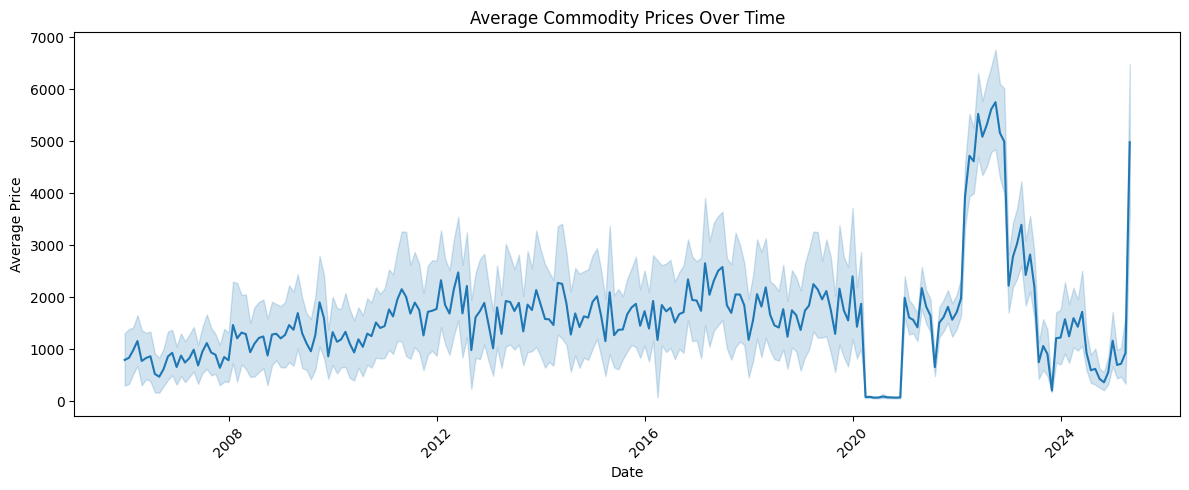

In [27]:
#Price Trends Over Time
plt.figure(figsize=(12, 5))
sns.lineplot(data=merged, x="date", y="price", estimator='mean')
plt.title("Average Commodity Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Average Price")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/folders/hk/9q5rgqm970gcnk6z0xvy1p7m0000gn/T/ipykernel_97522/2618350424.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_markets.values, y=top_markets.index, palette='viridis')


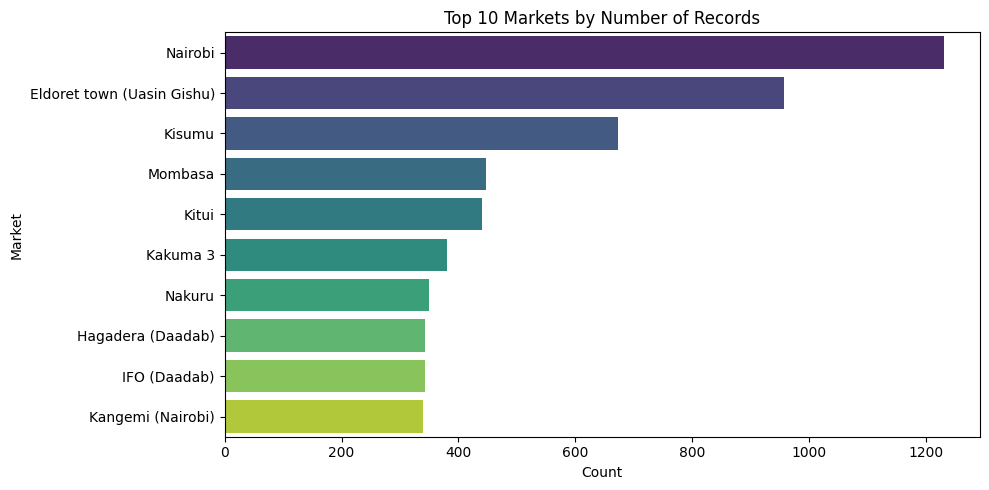

In [28]:
#Top 10 Markets by Records
top_markets = merged['market_x'].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_markets.values, y=top_markets.index, palette='viridis')
plt.title("Top 10 Markets by Number of Records")
plt.xlabel("Count")
plt.ylabel("Market")
plt.tight_layout()
plt.show()

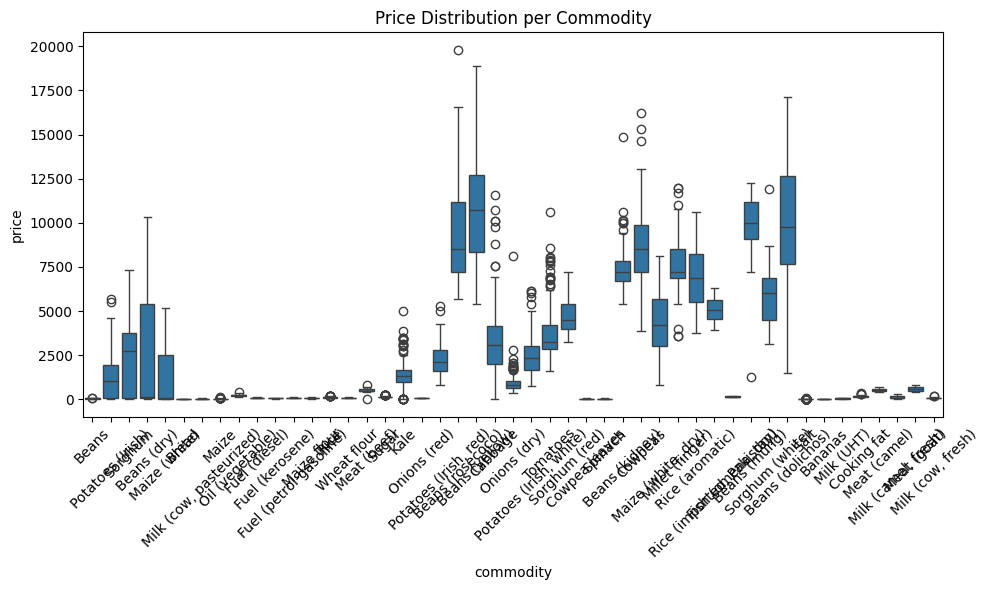

In [29]:
#Price Distribution by Commodity
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged, x='commodity', y='price')
plt.title("Price Distribution per Commodity")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [30]:
merged

,date_x,Region,County,market_x,market_id,latitude_x,longitude_x,category,commodity,commodity_id,...,date_y,rainfall_mm,market_y,countryiso3,admin1,admin2,latitude_y,longitude_y,year,date
0,2006-01-15,Coast,Mombasa,Mombasa,191,-4.05,39.67,pulses and nuts,Beans,50,...,chirps-v3.0.2006.01,1.223553,Mombasa,KEN,Coast,Mombasa,-4.05,39.67,2006,2006-01-01
1,2006-01-15,Eastern,Kitui,Kitui,187,-1.37,38.02,cereals and tubers,Potatoes (Irish),148,...,chirps-v3.0.2006.01,14.709594,Kitui,KEN,Eastern,Kitui,-1.37,38.02,2006,2006-01-01
2,2006-01-15,Eastern,Kitui,Kitui,187,-1.37,38.02,cereals and tubers,Sorghum,65,...,chirps-v3.0.2006.01,14.709594,Kitui,KEN,Eastern,Kitui,-1.37,38.02,2006,2006-01-01
3,2006-01-15,Eastern,Kitui,Kitui,187,-1.37,38.02,pulses and nuts,Beans (dry),262,...,chirps-v3.0.2006.01,14.709594,Kitui,KEN,Eastern,Kitui,-1.37,38.02,2006,2006-01-01
4,2006-01-15,Eastern,Marsabit,Marsabit,190,2.33,37.98,cereals and tubers,Maize (white),67,...,chirps-v3.0.2006.01,6.539468,Marsabit,KEN,Eastern,Marsabit,2.33,37.98,2006,2006-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12743,2025-04-15,Rift Valley,Turkana,Kakuma 4,3249,3.74,34.81,miscellaneous food,Salt,185,...,chirps-v3.0.2025.04,66.158401,Kakuma 4,KEN,Rift Valley,Turkana,3.74,34.81,2025,2025-04-01
12744,2025-04-15,Rift Valley,Turkana,Kakuma 4,3249,3.74,34.81,miscellaneous food,Sugar,97,...,chirps-v3.0.2025.04,66.158401,Kakuma 4,KEN,Rift Valley,Turkana,3.74,34.81,2025,2025-04-01
12745,2025-04-15,Rift Valley,Turkana,Kakuma 4,3249,3.74,34.81,oil and fats,Oil (vegetable),96,...,chirps-v3.0.2025.04,66.158401,Kakuma 4,KEN,Rift Valley,Turkana,3.74,34.81,2025,2025-04-01
12746,2025-04-15,Rift Valley,Turkana,Kakuma 4,3249,3.74,34.81,pulses and nuts,Beans (dry),262,...,chirps-v3.0.2025.04,66.158401,Kakuma 4,KEN,Rift Valley,Turkana,3.74,34.81,2025,2025-04-01


### 1.3 **Data Cleaning & Preparation for the merged dataset**

We clean the merged dataset by handling missing values, standardizing formats, and preparing it for modeling.


In [31]:
merged_prices_df = merged.drop_duplicates()
merged_prices_df = merged_prices_df.dropna(subset=['price', 'rainfall_mm', 'commodity_id'])

# Standardize date and numeric types
merged_prices_df['date'] = pd.to_datetime(merged_prices_df['date_x']) 
merged_prices_df[['price', 'rainfall_mm']] = merged_prices_df[['price', 'rainfall_mm']].apply(pd.to_numeric, errors='coerce')
merged_prices_df = merged_prices_df.dropna(subset=['price', 'rainfall_mm'])


In [32]:
merged_prices_df

,date_x,Region,County,market_x,market_id,latitude_x,longitude_x,category,commodity,commodity_id,...,date_y,rainfall_mm,market_y,countryiso3,admin1,admin2,latitude_y,longitude_y,year,date
0,2006-01-15,Coast,Mombasa,Mombasa,191,-4.05,39.67,pulses and nuts,Beans,50,...,chirps-v3.0.2006.01,1.223553,Mombasa,KEN,Coast,Mombasa,-4.05,39.67,2006,2006-01-15
1,2006-01-15,Eastern,Kitui,Kitui,187,-1.37,38.02,cereals and tubers,Potatoes (Irish),148,...,chirps-v3.0.2006.01,14.709594,Kitui,KEN,Eastern,Kitui,-1.37,38.02,2006,2006-01-15
2,2006-01-15,Eastern,Kitui,Kitui,187,-1.37,38.02,cereals and tubers,Sorghum,65,...,chirps-v3.0.2006.01,14.709594,Kitui,KEN,Eastern,Kitui,-1.37,38.02,2006,2006-01-15
3,2006-01-15,Eastern,Kitui,Kitui,187,-1.37,38.02,pulses and nuts,Beans (dry),262,...,chirps-v3.0.2006.01,14.709594,Kitui,KEN,Eastern,Kitui,-1.37,38.02,2006,2006-01-15
4,2006-01-15,Eastern,Marsabit,Marsabit,190,2.33,37.98,cereals and tubers,Maize (white),67,...,chirps-v3.0.2006.01,6.539468,Marsabit,KEN,Eastern,Marsabit,2.33,37.98,2006,2006-01-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12743,2025-04-15,Rift Valley,Turkana,Kakuma 4,3249,3.74,34.81,miscellaneous food,Salt,185,...,chirps-v3.0.2025.04,66.158401,Kakuma 4,KEN,Rift Valley,Turkana,3.74,34.81,2025,2025-04-15
12744,2025-04-15,Rift Valley,Turkana,Kakuma 4,3249,3.74,34.81,miscellaneous food,Sugar,97,...,chirps-v3.0.2025.04,66.158401,Kakuma 4,KEN,Rift Valley,Turkana,3.74,34.81,2025,2025-04-15
12745,2025-04-15,Rift Valley,Turkana,Kakuma 4,3249,3.74,34.81,oil and fats,Oil (vegetable),96,...,chirps-v3.0.2025.04,66.158401,Kakuma 4,KEN,Rift Valley,Turkana,3.74,34.81,2025,2025-04-15
12746,2025-04-15,Rift Valley,Turkana,Kakuma 4,3249,3.74,34.81,pulses and nuts,Beans (dry),262,...,chirps-v3.0.2025.04,66.158401,Kakuma 4,KEN,Rift Valley,Turkana,3.74,34.81,2025,2025-04-15


# 1.4 Feature Engineering

We create new features from the cleaned data to improve model performance.  
This includes extracting date-based features, encoding categorical variables, and generating useful interaction terms.


In [33]:
merged_prices_df.columns

Index(['date_x', 'Region', 'County', 'market_x', 'market_id', 'latitude_x',
       'longitude_x', 'category', 'commodity', 'commodity_id', 'unit',
       'priceflag', 'pricetype', 'currency', 'price', 'usdprice', 'geometry',
       'index_right', 'GID_2', 'GID_0', 'COUNTRY', 'GID_1', 'NAME_1',
       'NL_NAME_1', 'NAME_2', 'VARNAME_2', 'NL_NAME_2', 'TYPE_2', 'ENGTYPE_2',
       'CC_2', 'HASC_2', 'month', 'county', 'district', 'date_y',
       'rainfall_mm', 'market_y', 'countryiso3', 'admin1', 'admin2',
       'latitude_y', 'longitude_y', 'year', 'date'],
      dtype='object')

In [34]:
# 2.1 Extract time features
merged_prices_df['month'] = merged_prices_df['date'].dt.month
merged_prices_df['year']  = merged_prices_df['date'].dt.year

# 2.2 Encode categorical variables
for col in ['commodity', 'market_x', 'Region', 'County']:
    merged_prices_df[col] = merged_prices_df[col].astype('category').cat.codes

# 2.3 Scale numeric variables
from sklearn.preprocessing import StandardScaler
num_cols = ['rainfall_mm', 'month', 'year']
scaler = StandardScaler()
merged_prices_df[num_cols] = scaler.fit_transform(merged_prices_df[num_cols])

# 2.4 Final feature matrix
features = ['rainfall_mm','month','year','commodity','market_x','Region','County']
X = merged_prices_df[features]
y = merged_prices_df['price']

# 1.5 Train-Test Split & Data Structuring

We split the data into training and testing sets to evaluate model performance on unseen data.  
This ensures the model generalizes well and doesn't overfit the training data.


In [35]:
# 3.1 Split the dataset into training, validation, and test sets
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# 2.0 Model Configuration – Neural Network + 4 Baselines

We define a feedforward neural network using TensorFlow/Keras to model nonlinear relationships in the data.  
We also prepare baseline models (Ridge, Random Forest, Gradient Boosting) for comparison.


In [36]:
#importing necessary libraries
import numpy as np
from tensorflow import keras
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. Build Neural Network
# -----------------------------
def build_nn_model(input_dim, config):
    inp = keras.Input(shape=(input_dim,))
    x = inp
    for h in config['hidden_units']:
        x = keras.layers.Dense(h, activation=config['activation'])(x)
        x = keras.layers.Dropout(config['dropout'])(x)
    out = keras.layers.Dense(1)(x)
    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(config['lr']), loss='mse', metrics=['mae'])
    return model

## 2.1 Neural Network Configuration and Model Training

We configure the neural network with two hidden layers and ReLU activation.  
All models — including NeuralNet, Ridge, Random Forest, and Gradient Boosting — are trained and evaluated on the same dataset.

The best model is selected based on R² score and saved for deployment.


In [37]:
nn_config = {
    'hidden_units': [128, 64],
    'activation': 'relu',
    'dropout': 0.25,
    'lr': 1e-3,
    'batch_size': 64,
    'epochs': 50
}

# -----------------------------
#  Models
# -----------------------------
models = {
    'NeuralNet': build_nn_model(X_train.shape[1], nn_config),
    'RandomForest': RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=150, learning_rate=0.05, random_state=42),
    'Ridge': Ridge(alpha=0.5)
}

results = {}
metrics_summary = []
best_model_name = None
best_score = -np.inf

# Train, Predict, Evaluate
for name, model in models.items():
    print(f"\n Training {name}...")

    if name == 'NeuralNet':
        history = model.fit(X_train, y_train,
                            validation_data=(X_val, y_val),
                            batch_size=nn_config['batch_size'],
                            epochs=nn_config['epochs'],
                            verbose=0)
        preds = model.predict(X_test).flatten()
    else:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

    # Metrics
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    metrics_summary.append({
        'Model': name,
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2),
        'R2': round(r2, 3)
    })

    # Save model if best
    if r2 > best_score:
        best_model_name = name
        best_score = r2
        if name == 'NeuralNet':
            model.save('best_neural_net.h5')
        else:
            joblib.dump(model, f'best_model_{name}.pkl')

    results[name] = {
        'predictions': preds,
        'model_obj': model,
        'mae': mae,
        'rmse': rmse,
        'r2': r2
    }


 Training NeuralNet...
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step



 Training RandomForest...

 Training GradientBoosting...

 Training Ridge...


## 2.2 Metrics Summary

We compare all models using standard regression metrics:  
- **MAE** (Mean Absolute Error)  
- **RMSE** (Root Mean Squared Error)  
- **R² Score** (Goodness of fit)

The model with the highest R² score is selected as the best-performing model for deployment.


In [38]:
print("\n Evaluation Summary:")
metrics_df = pd.DataFrame(metrics_summary)
print(metrics_df.sort_values(by='R2', ascending=False))


 Evaluation Summary:
              Model      MAE     RMSE     R2
1      RandomForest   363.06   761.50  0.928
2  GradientBoosting   946.05  1398.66  0.757
0         NeuralNet  1611.42  2279.24  0.355
3             Ridge  2081.50  2750.71  0.061


## 2.3 Visualize Performance

We use a horizontal bar plot to compare the **R² scores** of all models, highlighting overall model accuracy (higher is better).

The model with the highest R² score is selected as the best performer for deployment.


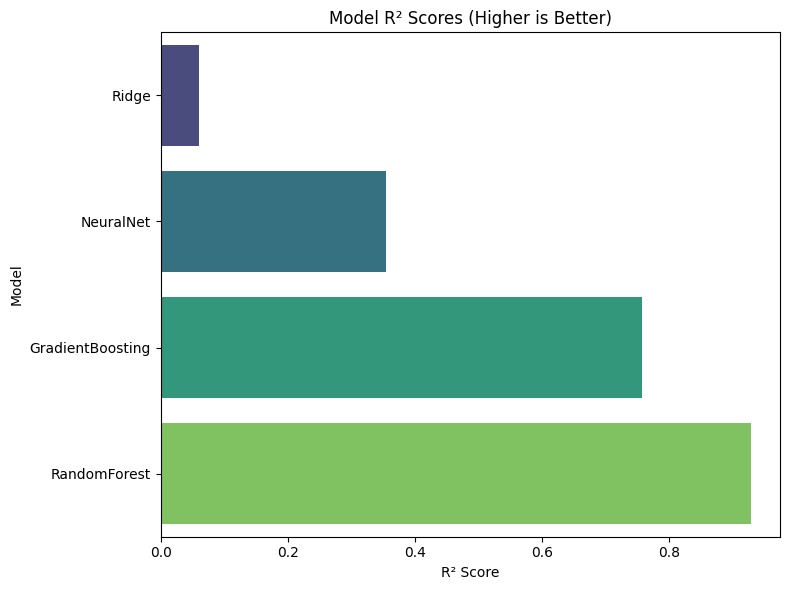


 Best Model: RandomForest with R² = 0.928


In [39]:
plt.figure(figsize=(8, 6))
sns.barplot(
    data=metrics_df.sort_values('R2'),
    x='R2',
    y='Model',
    hue='Model',           # Assign hue
    palette='viridis',
    dodge=False            # Optional: avoid multiple bars per model
)
plt.title("Model R² Scores (Higher is Better)")
plt.xlabel("R² Score")
plt.ylabel("Model")
plt.legend([], [], frameon=False)  # Remove the legend manually
plt.tight_layout()
plt.show()

# Print best model after visualization
print(f"\n Best Model: {best_model_name} with R² = {round(best_score, 3)}")


## 5.2 Comparison Table

This section will present a side-by-side summary of the performance metrics for all models evaluated:

- **MAE (Mean Absolute Error)**: Measures the average magnitude of errors in a set of predictions.
- **RMSE (Root Mean Squared Error)**: Similar to MAE but gives higher weight to large errors.
- **R² Score**: Indicates how well the model explains the variability of the target variable.

The table below (to be added) will help identify which model performed best across different metrics.


In [40]:
import pandas as pd

comparison_df = pd.DataFrame(metrics_summary)
print("\n Model Comparison:\n")
print(comparison_df.sort_values(by="RMSE"))


 Model Comparison:

              Model      MAE     RMSE     R2
1      RandomForest   363.06   761.50  0.928
2  GradientBoosting   946.05  1398.66  0.757
0         NeuralNet  1611.42  2279.24  0.355
3             Ridge  2081.50  2750.71  0.061


In [41]:
# Select best model based on lowest RMSE
best_model_name = comparison_df.sort_values(by="RMSE").iloc[0]['Model']
best_model = results[best_model_name]['model_obj']

print(f"\n Best model: {best_model_name}")

# Save model
if best_model_name == 'NeuralNet':
    best_model.save("best_model_nn.keras")
else:
    joblib.dump(best_model, "best_model.pkl")



 Best model: RandomForest


## 5.3 Recommend

This section provides a simple function to generate price predictions using the best-performing model.

It takes in rainfall, time, commodity, and location codes and returns the predicted price. The trained best model is used to provide estimates, which can support decision-making for farmers, traders, and policymakers.

In [42]:
def recommend_crop(rainfall_mm, month, year, commodity_code, market_code, admin1_code, admin2_code):
    import numpy as np
    # Load model
    model = joblib.load("best_model.pkl")

    # Input: must be 2D array with correct order
    X_new = np.array([[rainfall_mm, month, year, commodity_code, market_code, admin1_code, admin2_code]])

    # Predict price
    predicted_price = model.predict(X_new)[0]
    return predicted_price

In [43]:
# Get unique commodity name-code pairs
commodity_map = merged[['commodity', 'commodity_id']].drop_duplicates()
print(commodity_map)

# convert to dictionary
commodity_dict = dict(zip(commodity_map['commodity'], commodity_map['commodity_id']))
print(commodity_dict)


                      commodity  commodity_id
0                         Beans            50
1              Potatoes (Irish)           148
2                       Sorghum            65
3                   Beans (dry)           262
4                 Maize (white)            67
5                         Bread            55
8       Milk (cow, pasteurized)           472
16                        Maize            51
72              Oil (vegetable)            96
2314              Fuel (diesel)           284
2315            Fuel (kerosene)           283
2316     Fuel (petrol-gasoline)           285
4383                Maize flour            76
4385                       Rice            52
4387                Wheat flour            58
4388                Meat (beef)           141
4389                      Sugar            97
4392                       Kale           796
4393               Onions (red)           110
4449      Potatoes (Irish, red)           890
4450           Beans (rosecoco)   

In [44]:
# Get unique market name-code pairs
market_map = merged[['market_x', 'market_id']].drop_duplicates()
print(market_map)

# Convert to dictionary
market_dict = dict(zip(market_map['market_x'], market_map['market_id']))
print(market_dict)


                    market_x  market_id
0                    Mombasa        191
1                      Kitui        187
4                   Marsabit        190
5                    Nairobi        184
11                   Mandera        189
...                      ...        ...
7904        Moroto (Mombasa)       4236
7991             Dadaab town       3243
8030            IFO (Daadab)       3255
8169  Kisumu Ndogo (Mombasa)       4245
8580           Marsabit town       3358

[61 rows x 2 columns]
{'Mombasa': 191, 'Kitui': 187, 'Marsabit': 190, 'Nairobi': 184, 'Mandera': 189, 'Kisumu': 186, 'Lodwar (Turkana)': 188, 'Eldoret town (Uasin Gishu)': 185, 'Nakuru': 1850, 'Kilifi': 1852, 'Garissa': 1855, 'Marigat (Baringo)': 1851, 'Kajiado': 1853, 'Karatina (Nyeri)': 5670, 'Vanga (Kwale)': 5893, 'Kitui town (Kitui)': 5892, 'Makueni': 5667, 'Wote town (Makueni)': 6352, 'Kitengela (Kajiado)': 5697, 'Garissa town (Garissa)': 3356, 'Takaba (Mandera)': 3267, 'Marigat town (Baringo)': 3355, 'Illbis

In [45]:
# Ensure there are no duplicates or missing values
unique_counties = merged[['County']].dropna().drop_duplicates().sort_values('County')
unique_regions = merged[['Region']].dropna().drop_duplicates().sort_values('Region')

# Generate mapping dicts without duplicates
county_dict = {name: idx for idx, name in enumerate(unique_counties['County'])}
region_dict = {name: idx for idx, name in enumerate(unique_regions['Region'])}

# Add mapped codes to the DataFrame
merged['county_code'] = merged['County'].map(county_dict)
merged['region_code'] = merged['Region'].map(region_dict)


In [46]:
with open("mappings.py", "w") as f:
    f.write("commodity_dict = " + str(commodity_dict) + "\n")
    f.write("market_dict = " + str(market_dict) + "\n")
    f.write("region_dict = " + str(region_dict) + "\n")
    f.write("county_dict = " + str(county_dict) + "\n")

In [47]:
def recommend_crop_user_friendly(rainfall_mm, month, year, commodity, market, Region, County):
    import numpy as np
    import joblib


    # Map input strings to model-ready numeric codes
    commodity_code = commodity_dict.get(commodity)
    market_code = market_dict.get(market)
    region_code = region_dict.get(Region)
    county_code = county_dict.get(County)

    # Check if all codes were found
    if None in [commodity_code, market_code, region_code, county_code]:
        raise ValueError("One or more inputs could not be mapped to codes.")

    # Load model
    model = joblib.load("best_model.pkl")  # Adjust if using a different model

    # Create input array
    X_new = np.array([[rainfall_mm, month, year, commodity_code, market_code, region_code, county_code]])

    # Predict price
    predicted_price = model.predict(X_new)[0]
    return predicted_price


In [48]:
recommendation = recommend_crop_user_friendly(6.0, 9, 2025,'Potatoes (Irish)','Kitui','Eastern', 'Kitui')
print("Predicted Price:", round(recommendation, 2))


Predicted Price: 2089.56


/Users/brianrono/anaconda3/envs/learn-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [49]:
import streamlit as st


st.set_page_config(page_title="🌽 Food Price Prediction", layout="centered")

st.title("🌾 Food Price Prediction App")
st.markdown("Predict crop prices based on location, commodity, and weather conditions.")

# Input fields
rainfall = st.number_input("Rainfall (mm)", min_value=0.0, format="%.2f")
month = st.selectbox("Month", list(range(1, 13)))
year = st.number_input("Year", value=2025, min_value=2000)

commodity = st.selectbox("Commodity", list(commodity_dict.keys()))
market = st.selectbox("Market", list(market_dict.keys()))
region = st.selectbox("Region", list(region_dict.keys()))
county = st.selectbox("County", list(county_dict.keys()))

# Prediction
if st.button("Predict Price"):
    try:
        predicted_price = recommend_crop_user_friendly(
            rainfall_mm=rainfall,
            month=month,
            year=year,
            commodity=commodity,
            market=market,
            Region=region,
            County=county
        )
        st.success(f"✅ Predicted Price: {predicted_price:.2f} KES")
    except Exception as e:
        st.error(f"❌ Error: {e}")


2025-07-24 13:56:05.975 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-24 13:56:05.975 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-24 13:56:06.208 
  command:

    streamlit run /Users/brianrono/anaconda3/envs/learn-env/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-07-24 13:56:06.208 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-24 13:56:06.208 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-24 13:56:06.209 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-24 13:56:06.209 Thread 'MainThread': missing ScriptRunContext! This warn